Initial preparation by Valery Ilin

Modified by: Elvira Zainulina

In [309]:
import pyrealsense2 as rs
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D

# Collecting frames for next dev

In [258]:
count_of_frames = 15
frames_between_frames_D435 = 20

# Iitial configs

In [259]:
# data filenames
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

In [260]:
# config fo D435
cfg_d435 = rs.config()
cfg_d435.enable_device_from_file(d435_filename)
cfg_d435.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe_d435 = rs.pipeline()
pipe_d435.start(cfg_d435)


In [261]:
# config fo T265
cfg_t265 = rs.config()
cfg_t265.enable_device_from_file(t265_filename)
cfg_t265.enable_stream(rs.stream.pose)
pipe_t265 = rs.pipeline()
pipe_t265.start(cfg_t265)

## Collecting frames

In [262]:
# rewind
for i in range(frames_between_frames_D435*count_of_frames*2):
    pipe_d435.wait_for_frames()

In [263]:
d435_frames = []
while len(d435_frames) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames.append(depth_frame)

In [264]:
pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    

## Test for frames

In [265]:
def count_diff_frames(frames):
    prev_frame = None
    for i, frame in enumerate(frames):
        if prev_frame is not None:
            print("Difference bw {0} and {1} frames is {2:.4f} ms".format(i, i-1, frame.get_timestamp()-prev_frame.get_timestamp()))
        prev_frame = frame

In [266]:
def get_diff_sensors(frames1, frames2):
    if len(frames1) != len(frames2):
        return
    else:
        for i in range(len(frames1)):
            print("Difference bw frames1[{0}] and frames2[{0}] frames is {1:.4f} ms".format(i, frames1[i].get_timestamp()-frames2[i].get_timestamp()))
        

In [267]:
count_diff_frames(d435_frames)
count_diff_frames(t265_frames)

Difference bw 1 and 0 frames is 666.7358 ms
Difference bw 2 and 1 frames is 667.3687 ms
Difference bw 3 and 2 frames is 666.8352 ms
Difference bw 4 and 3 frames is 667.0249 ms
Difference bw 5 and 4 frames is 667.2656 ms
Difference bw 6 and 5 frames is 666.6699 ms
Difference bw 7 and 6 frames is 667.3604 ms
Difference bw 8 and 7 frames is 666.8496 ms
Difference bw 9 and 8 frames is 666.9397 ms
Difference bw 10 and 9 frames is 667.1294 ms
Difference bw 11 and 10 frames is 667.0417 ms
Difference bw 12 and 11 frames is 667.0449 ms
Difference bw 13 and 12 frames is 670.6421 ms
Difference bw 14 and 13 frames is 663.5679 ms
Difference bw 1 and 0 frames is 669.8828 ms
Difference bw 2 and 1 frames is 664.8850 ms
Difference bw 3 and 2 frames is 664.9270 ms
Difference bw 4 and 3 frames is 669.9377 ms
Difference bw 5 and 4 frames is 664.8296 ms
Difference bw 6 and 5 frames is 669.9438 ms
Difference bw 7 and 6 frames is 664.8889 ms
Difference bw 8 and 7 frames is 669.9446 ms
Difference bw 9 and 8 f

In [268]:
get_diff_sensors(d435_frames, t265_frames)

Difference bw frames1[0] and frames2[0] frames is 0.5422 ms
Difference bw frames1[1] and frames2[1] frames is -2.6047 ms
Difference bw frames1[2] and frames2[2] frames is -0.1211 ms
Difference bw frames1[3] and frames2[3] frames is 1.7871 ms
Difference bw frames1[4] and frames2[4] frames is -1.1257 ms
Difference bw frames1[5] and frames2[5] frames is 1.3103 ms
Difference bw frames1[6] and frames2[6] frames is -1.9636 ms
Difference bw frames1[7] and frames2[7] frames is 0.5078 ms
Difference bw frames1[8] and frames2[8] frames is -2.5872 ms
Difference bw frames1[9] and frames2[9] frames is -0.5425 ms
Difference bw frames1[10] and frames2[10] frames is 1.6616 ms
Difference bw frames1[11] and frames2[11] frames is -1.1948 ms
Difference bw frames1[12] and frames2[12] frames is 1.0410 ms
Difference bw frames1[13] and frames2[13] frames is 1.7087 ms
Difference bw frames1[14] and frames2[14] frames is 0.3694 ms


# Analysis

## Helpers

In [269]:
import time
from functools import wraps

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        time_start = time.time()
        result = f(*args, **kw)
        time_end = time.time()
        print('----------func:%r took: %2.4f sec' % (f.__name__, time_end-time_start))
        return result
    return wrap

In [270]:
tm_T265toD435 = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                          [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                          [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                          [0, 0, 0, 1]])

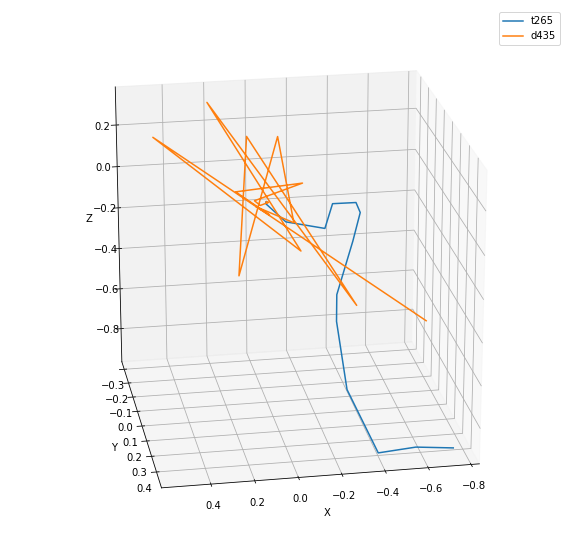

In [271]:
# Graph plot
t265 = np.load('../logs/points_trajectory_T265.npy') #np array coords
d435 = np.load('../logs/points_trajectory_D435.npy')/1 # np array coords
# before = 10
before = d435.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(t265[:before, 0], t265[:before, 1], t265[:before, 2], label='t265')
ax.plot(d435[:before, 0], d435[:before, 1], d435[:before, 2], label='d435')
ax.view_init(elev=22, azim=80)
plt.legend()

## Functions

In [272]:
def get_transformation265(pose):
    data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_dcm())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [274]:
get_transformation265(t265_frames[0])

array([[ 0.99645192, -0.06626671, -0.05188738, -2.90467   ],
       [ 0.08394013,  0.82740633,  0.55529526,  0.39048   ],
       [ 0.00613436, -0.55768046,  0.83003306, -0.873487  ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [275]:
def apply_transformation(transformation, points):
    """

    :param transformation: 4x4 np.array
    :param points: Nx3 np.array
    :return: transformed Nx3 np.array
    """
    if transformation is None or points is None:
        return None
    else:
        coordinates = np.hstack((points, np.ones((points.shape[0], 1))))
        return (transformation @ coordinates.T).T[:, :-1]

In [276]:
def get_coordinates(depth_frame, make_sampling=True, koef = 2**2):
    """
     TODO
    :param make_sampling:
    :return:
    """
    pc = rs.pointcloud()
    if make_sampling:
        decimate = rs.decimation_filter()
        decimate.set_option(rs.option.filter_magnitude, koef)
        depth_frame = decimate.process(depth_frame)

        points = pc.calculate(depth_frame).as_points()
    else:
        points = pc.calculate(depth_frame).as_points()

    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(points.size(), 3))
    coordinates = coordinates[coordinates[:, 2] != 0]

    coordinates = apply_transformation(tm_T265toD435, coordinates)
    return coordinates


In [277]:
get_coordinates(d435_frames[0]).shape

(23671, 3)

In [278]:
def convert_to_pcl(points):
    """
        TODO
    :param points: Nx3
    :return:
    """
    if points is None:
        return None
    else:
        return o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

In [279]:
convert_to_pcl(get_coordinates(d435_frames[0]))

geometry::PointCloud with 23671 points.

In [280]:
# TODO this 100%

def get_transformation435(self, max_point_pair_dist=0.2, init_guess=np.eye(4)):
    old_point_cloud = self.apply_transformation(self.prev_tm, self.point_cloud)
    old_pcl = self.convert_to_pcl(old_point_cloud) # n-1
    self.point_cloud = self.apply_transformation(self.prev_tm, self.get_coordinates())
    if old_pcl is None:
        self.prev_tm = init_guess
        print("\n\n\n{}\n\n\n".format(init_guess))
        return None

    new_pcl = self.convert_to_pcl(self.point_cloud) # n

    tr_mx = o3d.registration.registration_icp(old_pcl, new_pcl, max_point_pair_dist,
                                              self.prev_tm, o3d.registration.TransformationEstimationPointToPoint())\
        .transformation
    self.prev_tm = tr_mx
    return tr_mx

In [281]:
def plot_PC(Y, TX, ax=None, plot_lines=True):
    ax_is_None = False
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax_is_None = True
    ax.plot(Y[:,0], Y[:,1], Y[:,2], 'o', label='source points')
    ax.plot(TX[:,0], TX[:,1], TX[:,2], 'o', label='dest points')
    if plot_lines:
        for i in range(Y.shape[0]):
            ax.plot([Y[i,0], TX[i,0]], [Y[i,1], TX[i,1]], [Y[i,2], TX[i,2]], 
                    'g--')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    
    if ax_is_None:
        plt.tight_layout()
        plt.show()

In [282]:
d435_frames

In [283]:
t265_frames

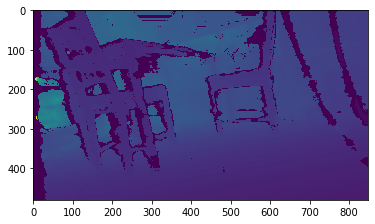

In [306]:
from IPython.display import clear_output

for i in range(len(d435_frames)):
    clear_output(wait=True)
    plt.imshow(d435_frames[i].get_data())
    plt.show()

In [285]:
points = [get_coordinates(depth) for depth in d435_frames]
pcl = [convert_to_pcl(point) for point in points]

In [286]:
regs = []
tr_mxs = []

for i in range(1, len(points)):
    reg = o3d.registration.registration_icp(pcl[i-1], pcl[i], 5)
    print(i, reg.fitness, reg.inlier_rmse)
    tr_mx = reg.transformation
    regs.append(reg)
    tr_mxs.append(tr_mx)

1 1.0 0.014729534189213422
2 1.0 0.08163211172356342
3 0.9984009426022555 0.09133419205838947
4 1.0 0.04370450815885146
5 1.0 0.03669567400801392
6 0.9999164089275265 0.03542839062283549
7 1.0 0.03573525849613253
8 1.0 0.06677465838795285
9 0.9991792656587473 0.248908940604052
10 0.9996205413609917 0.10016206699583499
11 1.0 0.041911441411997784
12 0.9999151211645376 0.0963820524390791
13 1.0 0.02286934267131559
14 1.0 0.02489356253019284


In [287]:
def visualise_transf(points0, points1, reg, size=30):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    cor = np.asarray(reg.correspondence_set)
    set0 = points0[cor[:, 0]]
    set1 = points1[cor[:, 1]]
    inds = np.random.choice(len(cor), size=size, replace=False)
    set0 = set0[inds]
    set1 = set1[inds]
    plot_PC(set0, set1, ax1)
    Tset0 = (reg.transformation @ (np.vstack((set0.T, np.ones(set0.shape[0]))))).T
    plot_PC(Tset0, set1, ax2)
    plt.tight_layout()
    plt.show()
    return set0, set1, Tset0


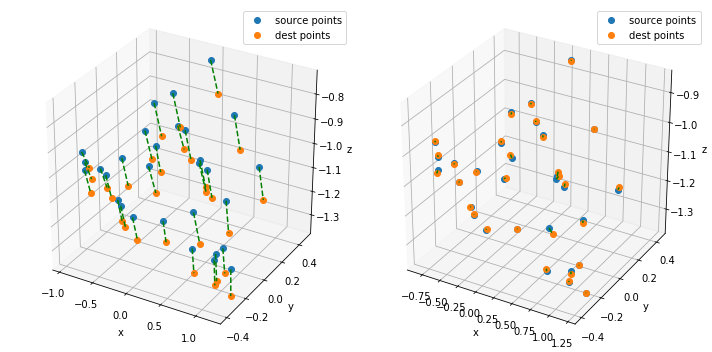

In [288]:
set0, set1, Tset0 = visualise_transf(points[0], points[1], regs[0])

In [295]:
trajectory = [np.zeros(3)]
R_ = np.eye(3)
poses = [R_]

In [296]:
for i in range(len(tr_mxs)):
    t_est = tr_mxs[0][:3, -1]
    R_est = tr_mxs[0][:3, :3]

    R_ = R_est @ R_
    t = trajectory[-1] + (np.linalg.inv(R_) @ t_est).ravel()
    
    trajectory.append(t) #-t moves point cloud into (0,0) of the initial state 
    poses.append(R_) #R_^-1 translates point cloud into the state of initial frame

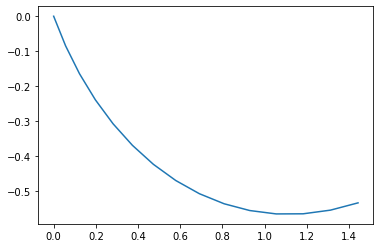

In [305]:
trajectory = np.array(trajectory)
plt.plot(trajectory[:, 1], trajectory[:, 2])

In [298]:
poses

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), array([[ 0.99970873,  0.02404153, -0.00210998],
        [-0.02379075,  0.9964105 ,  0.08124114],
        [ 0.00405557, -0.08116728,  0.99669224]]), array([[ 0.99883703,  0.04816102, -0.00225921],
        [-0.04715969,  0.98566779,  0.16197213],
        [ 0.01002757, -0.16167722,  0.98679275]]), array([[ 9.97391153e-01,  7.21850952e-02, -4.46603218e-04],
        [-6.99388345e-02,  9.67849105e-01,  2.41612644e-01],
        [ 1.78730762e-02, -2.40951078e-01,  9.70372676e-01]]), array([[ 0.9953815 ,  0.09594105,  0.0033148 ],
        [-0.09196444,  0.94308253,  0.31959018],
        [ 0.02753569, -0.31841899,  0.94755007]]), array([[ 0.99282251,  0.11925811,  0.00899796],
        [-0.11307817,  0.9115461 ,  0.39534419],
        [ 0.03894595, -0.39352409,  0.91848898]]), array([[ 0.98973259,  0.14196866,  0.01656202],
        [-0.13312825,  0.87346652,  0.46833012],
        [ 0.05202183, -0.46572646,  0.88339832]]), array([[

In [301]:
def plot_pose(c, pose, ax):
    for i, color in enumerate(['r', 'g', 'b']):
        ax.plot([c[0], pose[0, i]+c[0]], 
                [c[1], pose[1, i]+c[1]],
                [c[2], pose[2, i]+c[2]], color)
    
def plot_poses(trajectory, poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory[:,0], trajectory[:, 1], trajectory[:,2], 'k')
    for i, pose in enumerate(poses):
        plot_pose(trajectory[i], pose, ax)
#     ax.plot(points_trajectory_T265[:,0], points_trajectory_T265[:, 1], points_trajectory_T265[:, 2])
    plt.tight_layout()
    plt.show()

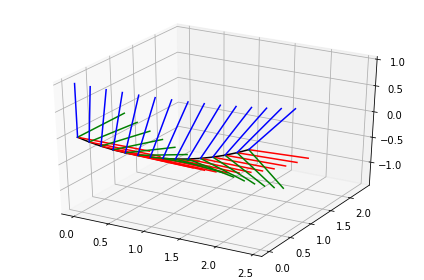

In [302]:
plot_poses(np.array(trajectory), np.array(poses))

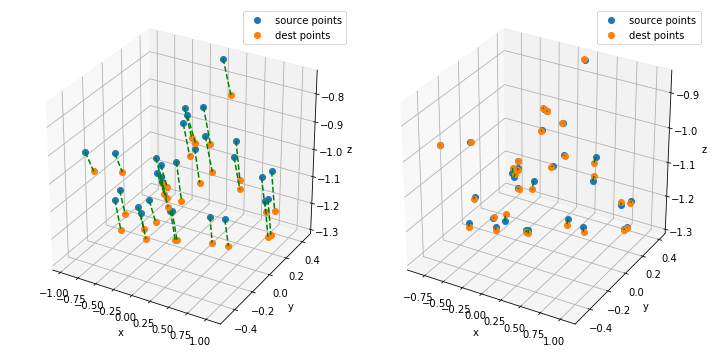

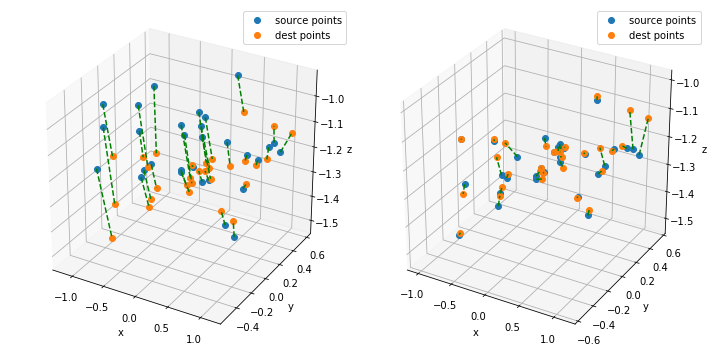

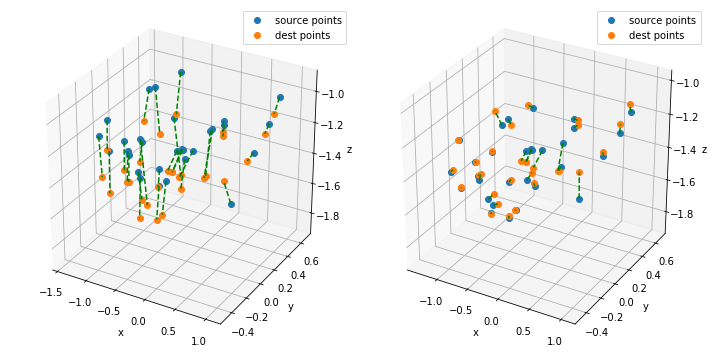

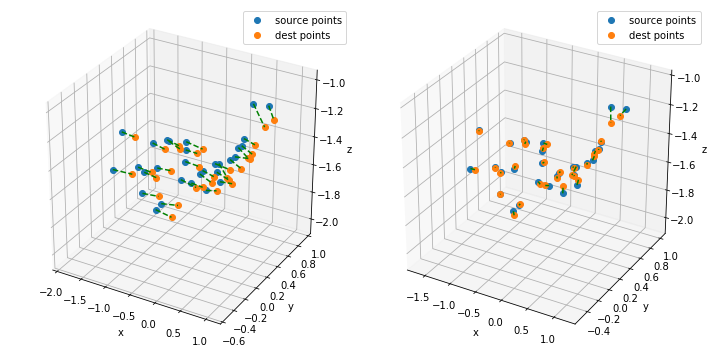

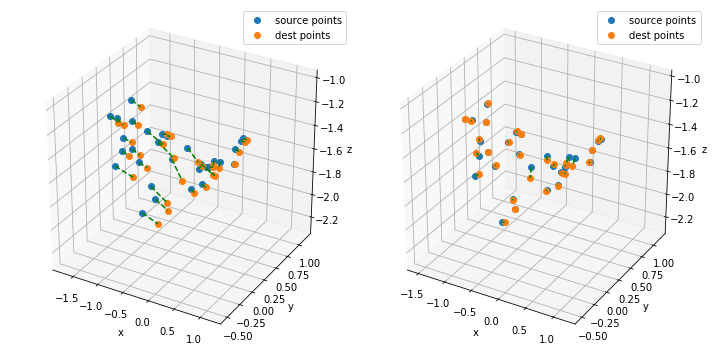

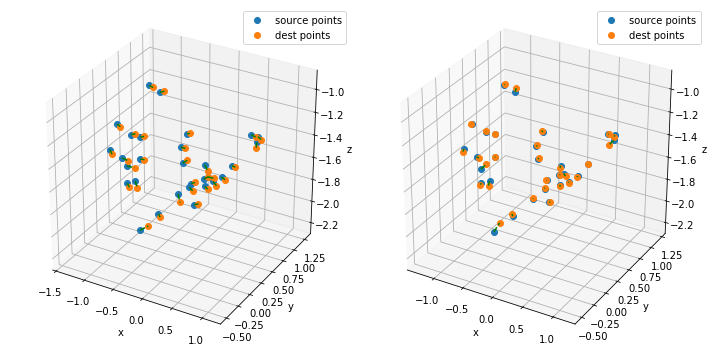

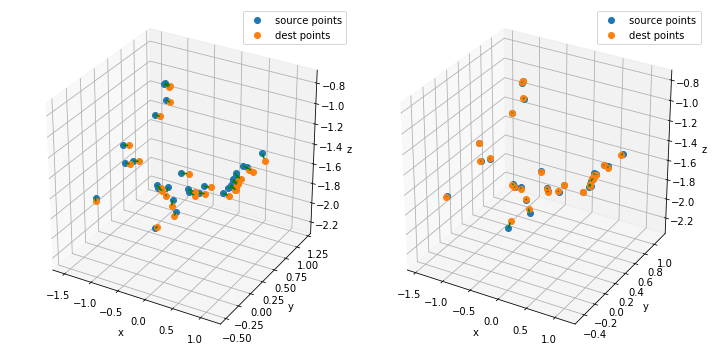

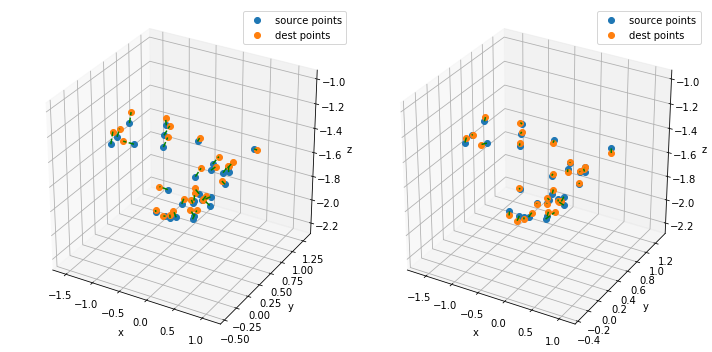

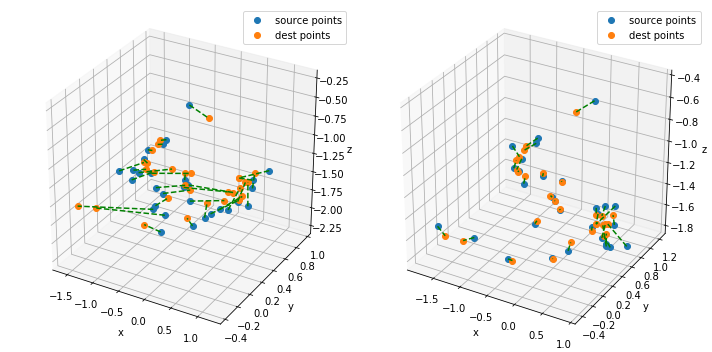

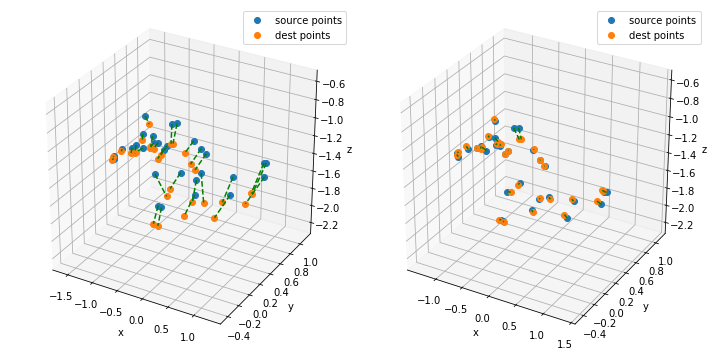

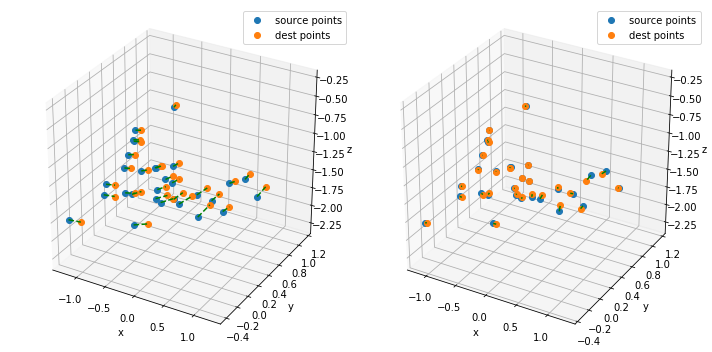

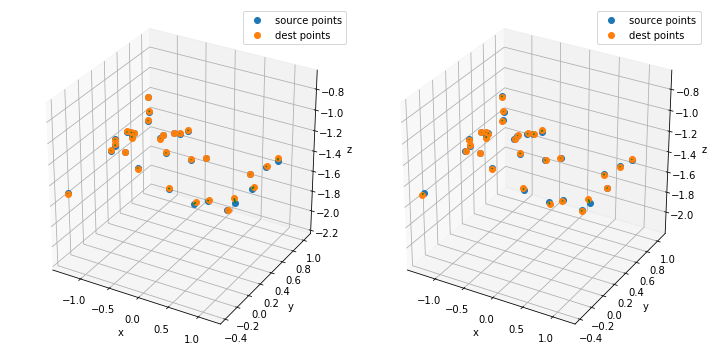

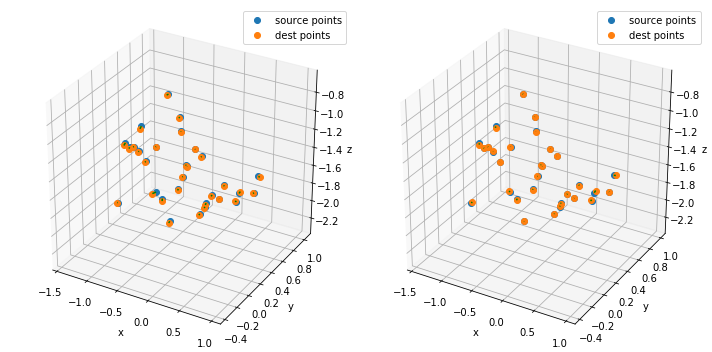

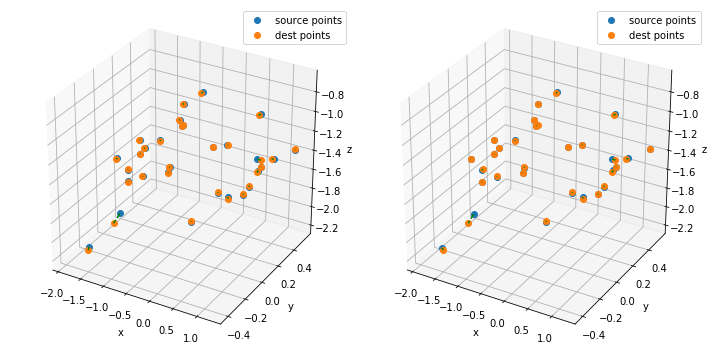

In [313]:
for i in range(len(tr_mxs)):
    _ = visualise_transf(points[i], points[i+1], regs[i])

In [171]:
np.mean(points[0], axis=0)

array([-0.12017239,  0.15306933, -1.37488087])

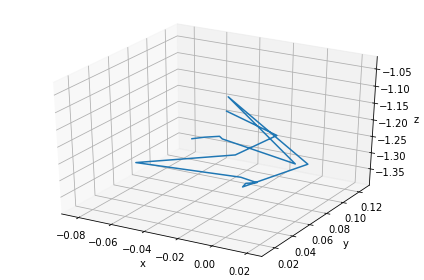

In [307]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tr = []
for i in range(len(points)):
#     ax.plot(points[i][:50,0], points[i][:50,1], points[i][:50,2], 'o', label=str(i))
    tr.append(np.mean(points[i], axis=0))
tr = np.array(tr)
ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()

plt.tight_layout()
plt.show()

In [310]:
points_trajectory_T265 = [[0, 0, 0]]
for pose in t265_frames:
    tr_mx = get_transformation265(pose)
    points_trajectory_T265.append(tr_mx[:3, -1])
points_trajectory_T265 = np.array(points_trajectory_T265)

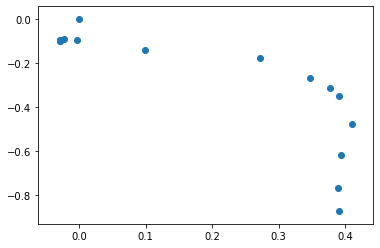

In [319]:
plt.scatter(points_trajectory_T265[:, 1], points_trajectory_T265[:, 2])

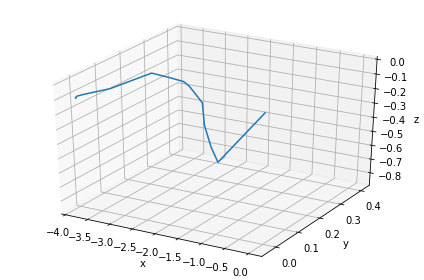

In [316]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()
ax.plot(points_trajectory_T265[:,0], points_trajectory_T265[:, 1], points_trajectory_T265[:, 2])
plt.tight_layout()
plt.show()